<a href="https://www.kaggle.com/code/hgvaishnavi/nyc-taxi-fare-prediction?scriptVersionId=234815933" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(geosphere)
library(lubridate)
library(ggplot2)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "nyc-taxi-fare-sample-dataset"

As the [dataset](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data) contains more than 55 Million rows and it take a lot of time to process, I am using sample data of 100,000 rows.


| **Sampling Method**     | **Representativeness** | **Best For**            | **Notes**                               |
|-------------------------|------------------------|-------------------------|-----------------------------------------|
| Random Sampling         | ⭐⭐⭐⭐⭐                  | Most accurate sampling  | Use shell shuf or clever R chunking     |
| Stratified Sampling     | ⭐⭐⭐⭐⭐                  | Imbalanced datasets     | Needs variable knowledge               |
| Sequential Sampling     | ⭐⭐                     | Quick previews          | Risk of bias                           |
| Systematic Sampling     | ⭐⭐                     | Quick approx. samples   | Risk of missing trends                 |

Used Random Sampling to get sample data because,

✅ Every row in your dataset has an equal chance of being included in the sample.

✅ Most representative of the population if truly random.

❗ Requires access to all row indices, which can be memory-heavy in R.

Use the shuf command to randomly select rows from the CSV.
shuf is a command-line utility available on Unix/Linux/macOS (and can be enabled in Windows via WSL or Git Bash).

📌 Command format on git bash:

shuf -n [sample_size] your_file.csv > sample.csv

This is how sample.csv was created.

In [2]:
library(data.table)

unclean_data <- fread("/kaggle/input/nyc-taxi-fare-sample-dataset/sample.csv")
clean_data <- unclean_data


Attaching package: ‘data.table’




The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year




The following objects are masked from ‘package:dplyr’:

    between, first, last




The following object is masked from ‘package:purrr’:

    transpose




In [3]:
summary(unclean_data)

      key                          fare_amount     pickup_datetime   
 Min.   :2009-01-01 00:37:48.00   Min.   : -3.50   Length:100000     
 1st Qu.:2010-08-20 22:47:17.25   1st Qu.:  6.00   Class :character  
 Median :2012-03-23 08:35:30.00   Median :  8.50   Mode  :character  
 Mean   :2012-03-22 07:40:50.83   Mean   : 11.31                     
 3rd Qu.:2013-10-19 23:34:04.50   3rd Qu.: 12.50                     
 Max.   :2015-06-30 23:43:33.00   Max.   :332.00                     
                                                                     
 pickup_longitude   pickup_latitude   dropoff_longitude dropoff_latitude  
 Min.   :-1329.48   Min.   :-764.56   Min.   :-735.05   Min.   :-1160.22  
 1st Qu.:  -73.99   1st Qu.:  40.73   1st Qu.: -73.99   1st Qu.:   40.73  
 Median :  -73.98   Median :  40.75   Median : -73.98   Median :   40.75  
 Mean   :  -72.57   Mean   :  39.93   Mean   : -72.52   Mean   :   39.93  
 3rd Qu.:  -73.97   3rd Qu.:  40.77   3rd Qu.: -73.96   3rd Qu.: 

If you observe the above summary,

*fare_amount:*
<br>Based on [this discussion](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/discussion/63319), the taxi fare within NYC is between 2.5 and 100.
<br>Hence any record that is not in this range, must be cleared.

*pickup_datetime:*
<br>Datatype must be changed.

*passenger_count:*
<br>No.of passengers cannot be less than 1.
<br>Max. capacity of taxi is 6.
<br>Hence any record that is not in this range, must be cleared.

*pickup and drop-off locations:*
<br>NYC Coordinates:
| **Type**     | **Approximate Range**  |
|--------------|------------------------|
| Latitude     | 40.5 to 41.0           |
| Longitude    | -74.25 to -73.70       |
<br>Any point that is outside of NYC, must be removed.
<br>Rides having same pickup and dropoff location must be removed.


#### Remove Null Values

In [4]:
sum(!complete.cases(unclean_data))

[1] 2

In [5]:
clean_data <- na.omit(unclean_data)

#### Remove records having same pickup and dropoff locations

In [6]:
nrow(clean_data[
  pickup_latitude == dropoff_latitude &
    pickup_longitude == dropoff_longitude])

[1] 2807

In [7]:
clean_data <- clean_data[!(pickup_latitude == dropoff_latitude & 
                              pickup_longitude == dropoff_longitude)]

#### Remove records with irrelevent fare amount

In [8]:
nrow(clean_data[fare_amount < 2.5 | fare_amount > 100])

[1] 36

In [9]:
clean_data <- clean_data[fare_amount >= 2.5 & fare_amount <= 100]

#### Remove records with irrelevent passenger count

In [10]:
nrow(clean_data[passenger_count > 6 | passenger_count < 1])

[1] 320

In [11]:
clean_data <- clean_data[passenger_count > 0 & passenger_count <= 6]

#### Remove irrelevent Pickup Locations

In [12]:
nrow(clean_data[
  pickup_latitude < 40.5 | pickup_latitude > 41 |
    pickup_longitude < -74.25 | pickup_longitude > -73.7])

[1] 196

In [13]:
clean_data <- clean_data[
  pickup_latitude >= 40.5 & pickup_latitude <= 41 & 
    pickup_longitude >= -74.25 & pickup_longitude <= -73.7
]

#### Remove irrelevent Dropoff Locations

In [14]:
nrow(clean_data[
  dropoff_latitude < 40.5 | dropoff_latitude > 41 |
    dropoff_longitude < -74.25 | dropoff_longitude > -73.7])

[1] 120

In [15]:
clean_data <- clean_data[
    dropoff_latitude >= 40.5 & dropoff_latitude <= 41 & 
        dropoff_longitude >= -74.25 & dropoff_longitude <= -73.7
]

#### Remove irrelevent distances

🚕 In real life:
<br>A taxi can be taken for very short distances, like 1–2 blocks.
<br>This might be as low as 0.1 to 0.3 km (100–300 meters).

<br>A typical maximum distance for NYC taxis would be:
<br>Around 30–50 km within NYC
<br>JFK to Manhattan is ~30 km
<br>Some trips may go even outside NYC (e.g., to Newark)
<br>So, realistic max trip distances could be up to 60 km, but anything beyond that is likely an outlier or error.

So, lets create a new column trip distance in km and remove the records where distance is less than 100m and greater than 60km 

In [16]:
clean_data$trip_distance_km <- distHaversine(
  matrix(c(clean_data$pickup_longitude, clean_data$pickup_latitude), ncol = 2),
  matrix(c(clean_data$dropoff_longitude, clean_data$dropoff_latitude), ncol = 2)
) / 1000

In [17]:
summary(clean_data$trip_distance_km)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00008  1.28162  2.17429  3.33658  3.93769 35.77145 

In [18]:
sum(clean_data$trip_distance_km < 0.1 | clean_data$trip_distance_km > 60, na.rm = TRUE)

[1] 574

In [19]:
clean_data <- clean_data[clean_data$trip_distance_km >= 0.1 & clean_data$trip_distance_km <= 60,  ]

#### Change the datatype of pickup_datetime

In [20]:
clean_data$pickup_datetime <- as.POSIXct(clean_data$pickup_datetime, format="%Y-%m-%d %H:%M:%S")

In [21]:
summary(clean_data)

      key                          fare_amount    
 Min.   :2009-01-01 00:37:48.00   Min.   :  2.50  
 1st Qu.:2010-08-18 19:42:00.00   1st Qu.:  6.00  
 Median :2012-03-28 22:47:21.00   Median :  8.50  
 Mean   :2012-03-25 02:59:59.53   Mean   : 11.26  
 3rd Qu.:2013-10-25 10:13:17.00   3rd Qu.: 12.50  
 Max.   :2015-06-30 23:43:33.00   Max.   :100.00  
 pickup_datetime                  pickup_longitude pickup_latitude
 Min.   :2009-01-01 00:37:48.00   Min.   :-74.24   Min.   :40.53  
 1st Qu.:2010-08-18 19:42:00.00   1st Qu.:-73.99   1st Qu.:40.74  
 Median :2012-03-28 22:47:21.00   Median :-73.98   Median :40.75  
 Mean   :2012-03-25 02:59:59.53   Mean   :-73.98   Mean   :40.75  
 3rd Qu.:2013-10-25 10:13:17.00   3rd Qu.:-73.97   3rd Qu.:40.77  
 Max.   :2015-06-30 23:43:33.00   Max.   :-73.71   Max.   :40.97  
 dropoff_longitude dropoff_latitude passenger_count trip_distance_km 
 Min.   :-74.23    Min.   :40.53    Min.   :1.000   Min.   : 0.1004  
 1st Qu.:-73.99    1st Qu.:40.74  

In [22]:
nrow(clean_data)

[1] 95945

### Visualizations

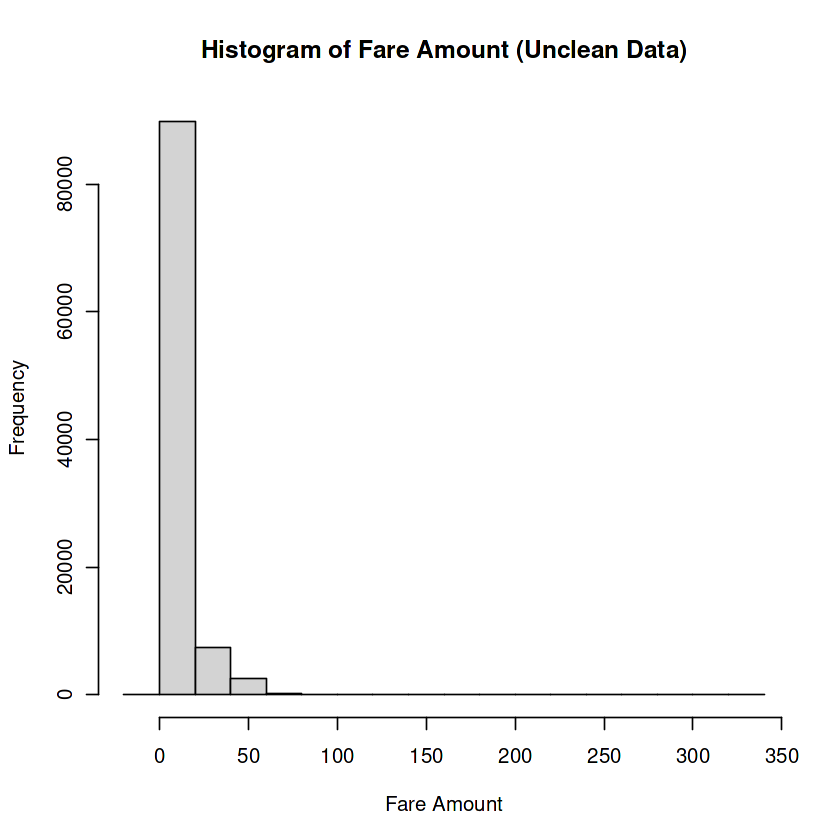

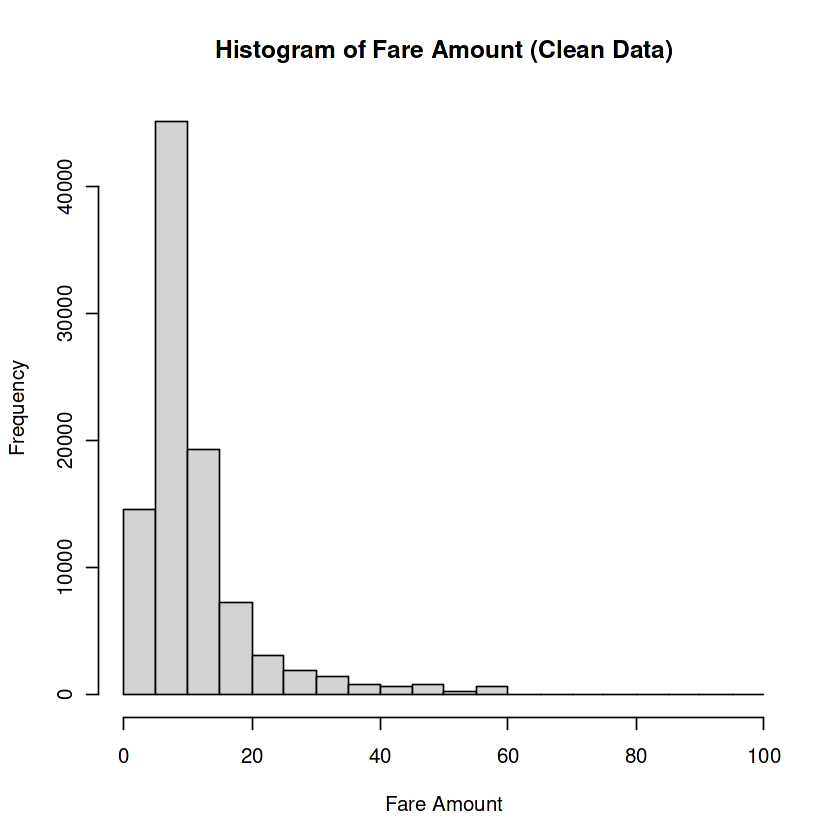

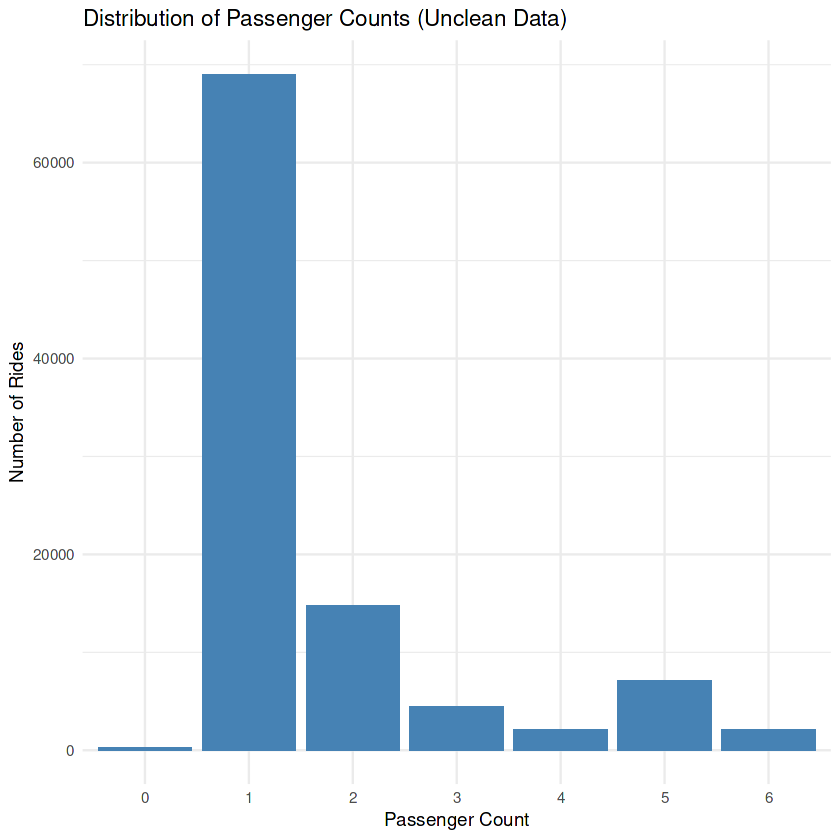

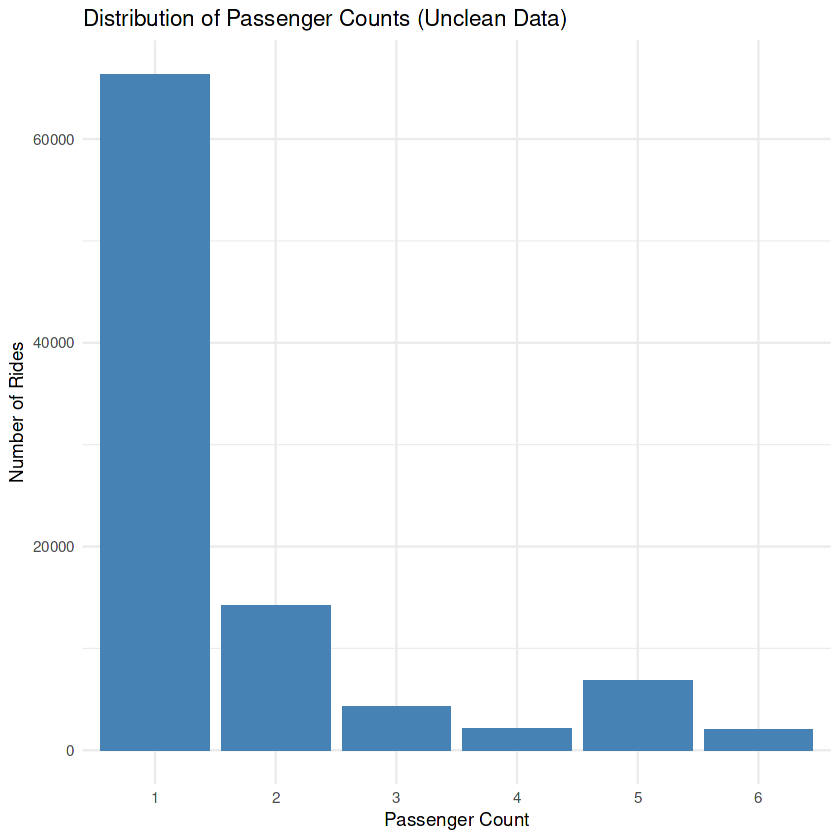

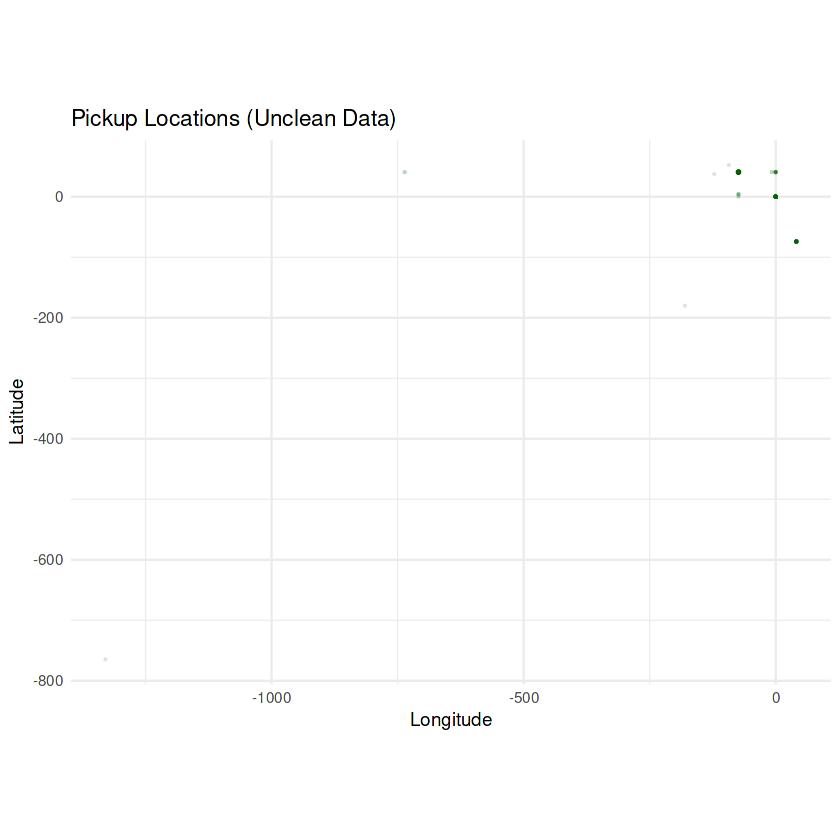

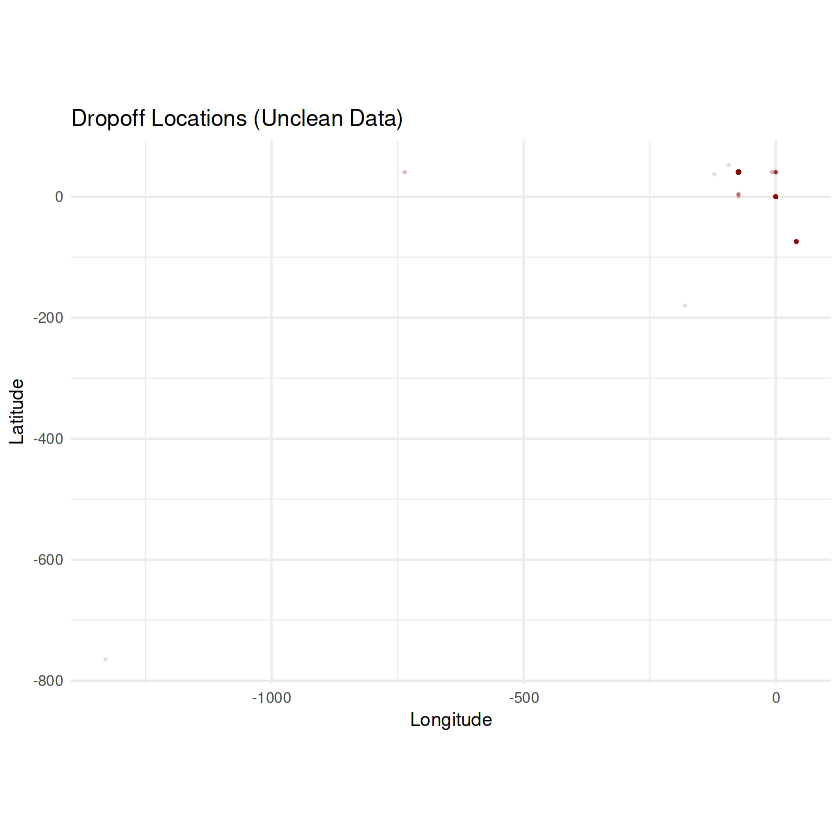

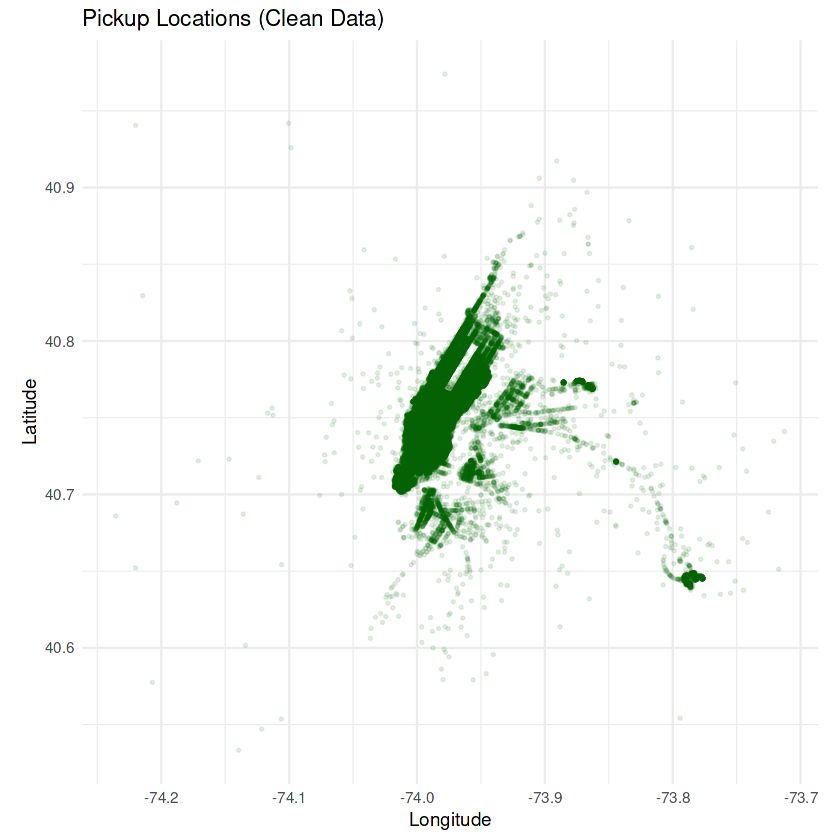

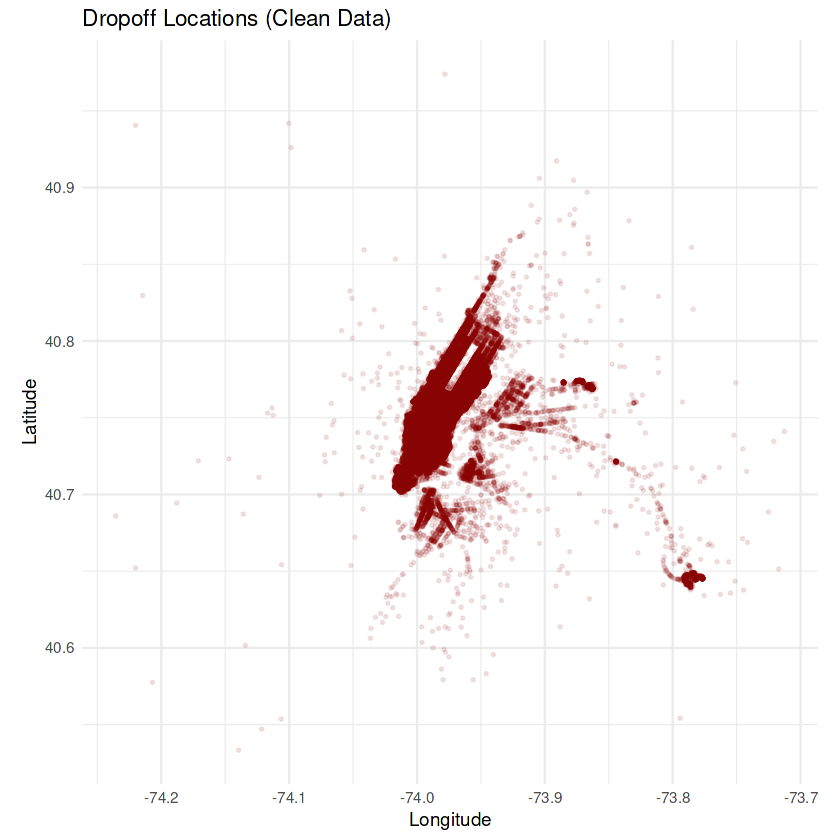

In [23]:


# fare amount
hist(unclean_data$fare_amount, main = "Histogram of Fare Amount (Unclean Data)", xlab = ("Fare Amount"))
hist(clean_data$fare_amount, main = "Histogram of Fare Amount (Clean Data)", xlab = ("Fare Amount"))

# passenger count
ggplot(unclean_data, aes(x = factor(passenger_count))) +
  geom_bar(fill = "steelblue") +
  labs(
    title = "Distribution of Passenger Counts (Unclean Data)",
    x = "Passenger Count",
    y = "Number of Rides"
  ) +
  theme_minimal()

ggplot(clean_data, aes(x = factor(passenger_count))) +
  geom_bar(fill = "steelblue") +
  labs(
    title = "Distribution of Passenger Counts (Unclean Data)",
    x = "Passenger Count",
    y = "Number of Rides"
  ) +
  theme_minimal()


# NYC plot for pickup

ggplot(unclean_data, aes(x = pickup_longitude, y = pickup_latitude)) +
  geom_point(alpha = 0.1, color = "darkgreen", size = 0.2) +
  coord_fixed(1.2) +
  labs(title = "Pickup Locations (Unclean Data)", x = "Longitude", y = "Latitude") +
  theme_minimal()

# NYC plot for dropoff

ggplot(unclean_data, aes(x = pickup_longitude, y = pickup_latitude)) +
  geom_point(alpha = 0.1, color = "darkred", size = 0.2) +
  coord_fixed(1.2) +
  labs(title = "Dropoff Locations (Unclean Data)", x = "Longitude", y = "Latitude") +
  theme_minimal()



# NYC plot for pickup

ggplot(clean_data, aes(x = pickup_longitude, y = pickup_latitude)) +
  geom_point(alpha = 0.1, color = "darkgreen", size = 0.5) +
  coord_fixed(1.2) +
  labs(title = "Pickup Locations (Clean Data)", x = "Longitude", y = "Latitude") +
  theme_minimal()

# NYC plot for dropoff

ggplot(clean_data, aes(x = pickup_longitude, y = pickup_latitude)) +
  geom_point(alpha = 0.1, color = "darkred", size = 0.5) +
  coord_fixed(1.2) +
  labs(title = "Dropoff Locations (Clean Data)", x = "Longitude", y = "Latitude") +
  theme_minimal()

In [24]:
library(leaflet)

set.seed(42)  # for reproducibility

      # pickup
leaflet(clean_data) %>%
  addTiles() %>%
  addCircleMarkers(
    lng = ~pickup_longitude,
    lat = ~pickup_latitude,
    radius = 1,
    color = "green",
    opacity = 0.5,
    popup = ~paste("Fare: $", fare_amount)
  ) %>%
  addLegend("bottomright", colors = "green", labels = "Pickup Locations")

      # dropoff
leaflet(clean_data) %>%
  addTiles() %>%
  addCircleMarkers(
    lng = ~dropoff_longitude,
    lat = ~dropoff_latitude,
    radius = 0.5,
    color = "red",
    opacity = 0.5,
    popup = ~paste("Fare: $", fare_amount)
  ) %>%
  addLegend("bottomright", colors = "red", labels = "Dropoff Locations")

HTML widgets cannot be represented in plain text (need html)

HTML widgets cannot be represented in plain text (need html)

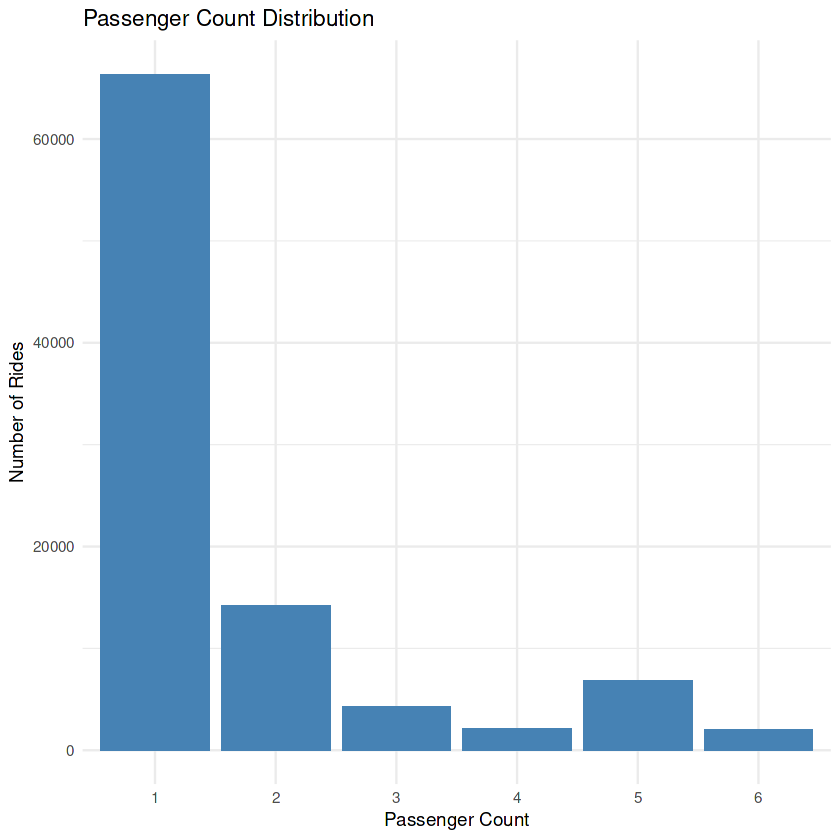

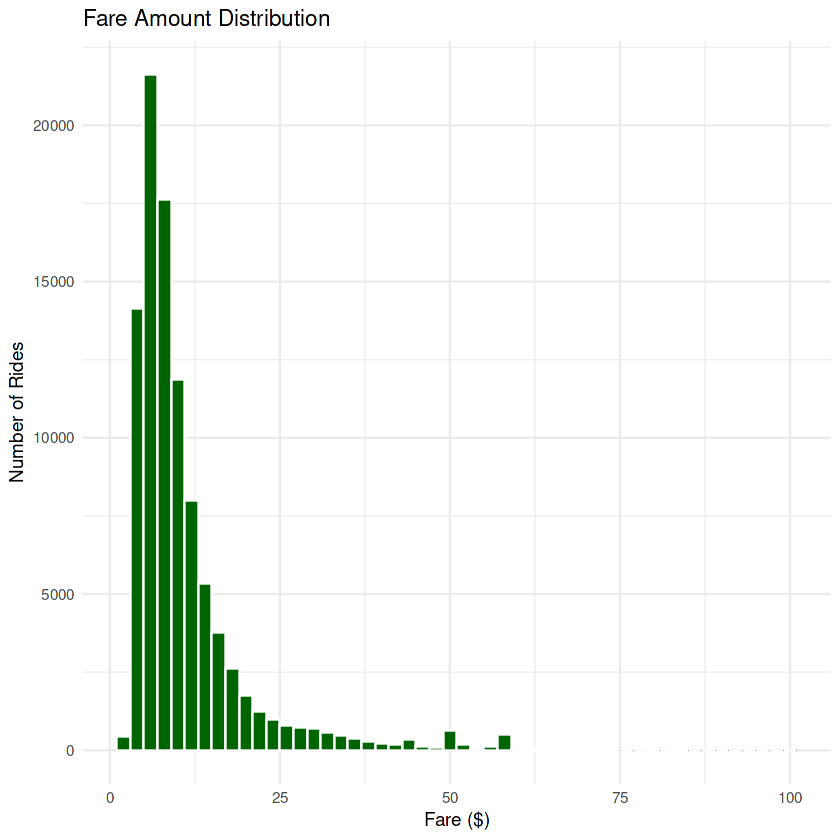

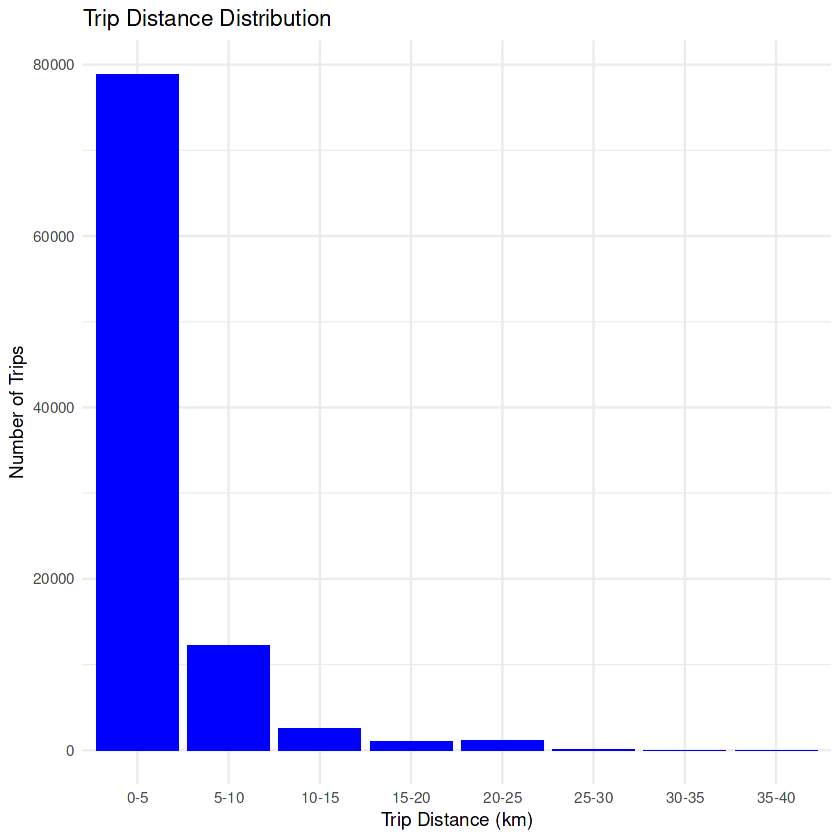

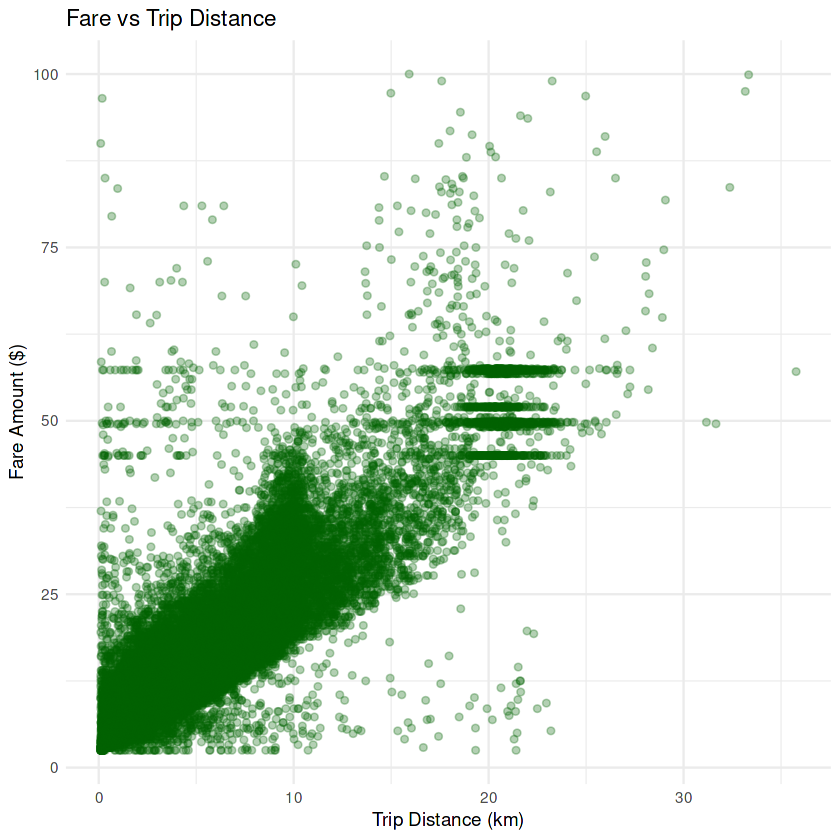

In [25]:
# Passenger Count Distribution

ggplot(clean_data, aes(x = as.factor(passenger_count))) +
  geom_bar(fill = "steelblue") +
  labs(title = "Passenger Count Distribution",
       x = "Passenger Count",
       y = "Number of Rides") +
  theme_minimal()



# Fare Amount Distribution

ggplot(clean_data, aes(x = fare_amount)) +
  geom_histogram(binwidth = 2, fill = "darkgreen", color = "white") +
  labs(title = "Fare Amount Distribution",
       x = "Fare ($)",
       y = "Number of Rides") +
  theme_minimal()



# Trip Distance

clean_data$distance_bin <- cut(
  clean_data$trip_distance_km,
  breaks = c(0, 5, 10, 15, 20, 25, 30, 35, 40, 45, Inf),
  labels = c("0-5", "5-10", "10-15", "15-20", "20-25", 
             "25-30", "30-35", "35-40", "40-45", "45+"),
  right = FALSE
)

ggplot(clean_data, aes(x = distance_bin)) +
  geom_bar(fill = "blue") +
  labs(title = "Trip Distance Distribution",
       x = "Trip Distance (km)",
       y = "Number of Trips") +
  theme_minimal()



# Fare vs Distance Relationship

ggplot(clean_data, aes(x = trip_distance_km, y = fare_amount)) +
  geom_point(alpha = 0.3, color = "darkgreen") +
  labs(title = "Fare vs Trip Distance",
       x = "Trip Distance (km)",
       y = "Fare Amount ($)") +
  theme_minimal()